     Subject  Start_Time From  To  Sojourn_Time  Censored
0          0    0.000000   S0  S2      1.687596         1
1          0    1.687596   S2  S0      0.472526         1
2          0    2.160122   S0  S1      3.662700         1
3          0    5.822822   S1  S0      0.635762         1
4          0    6.458584   S0  S1      2.082150         1
..       ...         ...  ...  ..           ...       ...
166       48    0.000000   S0  S2      0.533246         1
167       48    0.533246   S2  S1      3.561513         1
168       48    4.094759   S1  S3      2.301740         1
169       49    0.000000   S0  S1      0.889793         1
170       49    0.889793   S1  S3      1.164669         1

[171 rows x 6 columns]


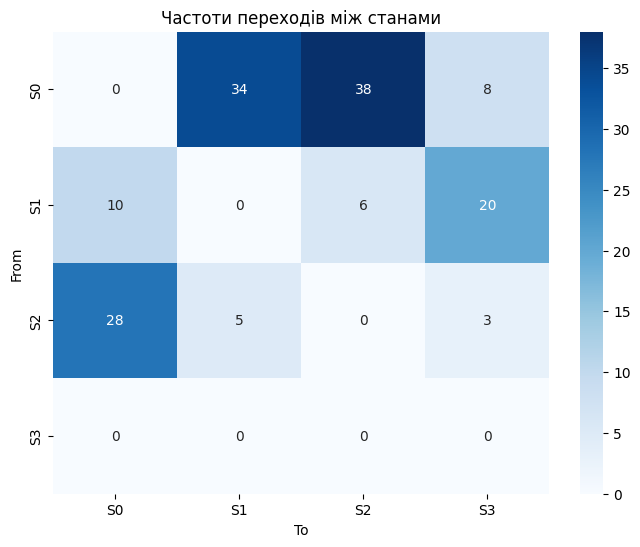

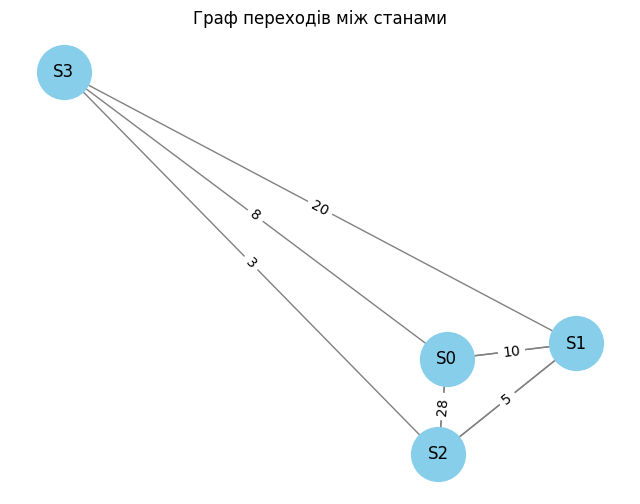

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Параметри моделювання
M = 50  # кількість суб'єктів
Tmax = 10  # максимальний час спостереження
N_states = 4  # кількість станів
state_names = [f'S{i}' for i in range(N_states)]

# Генерація випадкової матриці переходів (рядки сумуються до 1)
def generate_transition_matrix(n):
    mat = np.zeros((n, n))
    for i in range(n):
        probs = np.random.dirichlet(np.ones(n - 1))
        mat[i, :i] = probs[:i]
        mat[i, i+1:] = probs[i:]
    return pd.DataFrame(mat, index=state_names, columns=state_names)

transition_probs = generate_transition_matrix(N_states)

# Випадкове призначення базових інтенсивностей і типу розподілу
lambda_0 = {state: np.random.uniform(0.1, 1.0) for state in state_names}
lambda_type = {state: np.random.choice(['exp', 'unif']) for state in state_names}

# Функція для генерації наступного стану
def sample_next_state(current):
    return np.random.choice(state_names, p=transition_probs.loc[current].values)

# Функція для генерації часу перебування
def generate_sojourn_time(current_state, Z):
    lam = lambda_0.get(current_state, 1.0)
    if lambda_type[current_state] == 'exp':
        rate = lam * np.exp(Z)
        u = np.random.uniform(0, 1)
        return -np.log(1 - u) / rate
    else:  # рівномірний розподіл
        low = 0.5
        high = lam + np.exp(Z)
        return np.random.uniform(low, high)

# Основний алгоритм
records = []
for m in range(M):
    t = 0
    state = state_names[0]  # Початковий стан
    Z_m = {(i, j): np.random.normal(0, 1) for i in state_names for j in state_names if j != i}

    while t < Tmax and state != state_names[-1]:  # останній стан — absorbing
        current_state = state
        next_candidate = sample_next_state(current_state)
        Z = Z_m.get((current_state, next_candidate), 0)
        W = generate_sojourn_time(current_state, Z)

        if t + W > Tmax:
            W = Tmax - t
            censored = 0
            next_state = None
        else:
            censored = 1
            next_state = next_candidate

        records.append({
            'Subject': m,
            'Start_Time': round(t, 6),
            'From': current_state,
            'To': next_state,
            'Sojourn_Time': round(W, 6),
            'Censored': censored
        })

        t += W
        state = next_state

# Зберігаємо як DataFrame
sim_data = pd.DataFrame(records)

# Вивід
print(sim_data)

# Побудова графіка переходів (матриця частот)
transition_counts = sim_data.groupby(['From', 'To']).size().unstack(fill_value=0)
transition_counts = transition_counts.reindex(index=state_names, columns=state_names, fill_value=0)

plt.figure(figsize=(8, 6))
sns.heatmap(transition_counts, annot=True, fmt='d', cmap='Blues')
plt.title("Частоти переходів між станами")

# Побудова графіка переходів
valid_transitions = sim_data.dropna(subset=['To'])
transition_counts = valid_transitions.groupby(['From', 'To']).size()

# Створення графа
G = nx.DiGraph()
for (src, dst), weight in transition_counts.items():
    G.add_edge(src, dst, weight=weight)

# Позиції вузлів
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Граф переходів між станами")
plt.axis('off')

plt.show()
